## Image Segmentation with SAM Model

In this notebook, we'll demonstrate how to perform object detection using the SAM (Segment Anything Model) framework. SAM allows us to segment arbitrary objects in images using deep learning techniques. We'll use PyTorch and the SAM library to detect objects in images.

First, let's import the necessary libraries:

In [1]:
import os
import cv2
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np

from PIL import Image
from segment_anything import sam_model_registry 
from segment_anything import SamAutomaticMaskGenerator
from segment_anything import SamPredictor
from torch.utils.data import Dataset, DataLoader
import glob

import random
import numpy as np

### Purpose:

The main purpose of this class is to load a collection of images stored in a specified directory and apply optional transformations to preprocess the images before passing them to the object detection model.

In [2]:
class ObjectDetectionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.image_paths = sorted(glob.glob(os.path.join(root_dir, '*.png')))

        # Print the number of loaded images
        print(f"Number of images: {len(self.image_paths)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

# Dataset

https://www.kaggle.com/datasets/thomasfermi/lane-detection-for-carla-driving-simulator

In [3]:
root_dir = os.path.join("/kaggle/input/lane-detection-for-carla-driving-simulator/train")

transform = pth_transforms.Compose([
    pth_transforms.Resize((256, 256)),
    pth_transforms.ToTensor(),
])

dataset = ObjectDetectionDataset(root_dir=root_dir, transform=transform)

loader = DataLoader(dataset, batch_size=1, shuffle=False)

Number of images: 3075


# Segment Anything Model Initialization

In [4]:
sam_checkpoint = '/kaggle/input/segment-anything/pytorch/vit-l/1/model.pth'
model_type = "vit_l" #
device = "cpu" #cpu,cuda

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator1 = SamAutomaticMaskGenerator(sam, points_per_batch=16)
predictor = SamPredictor(sam)

# Defining the fuction for the image segmentation

In [5]:
# Define detect_lanes function

def detect_lanes(anns, axes=None):
    if len(anns) == 0:
        return
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m**0.5)))


(256, 256, 3)


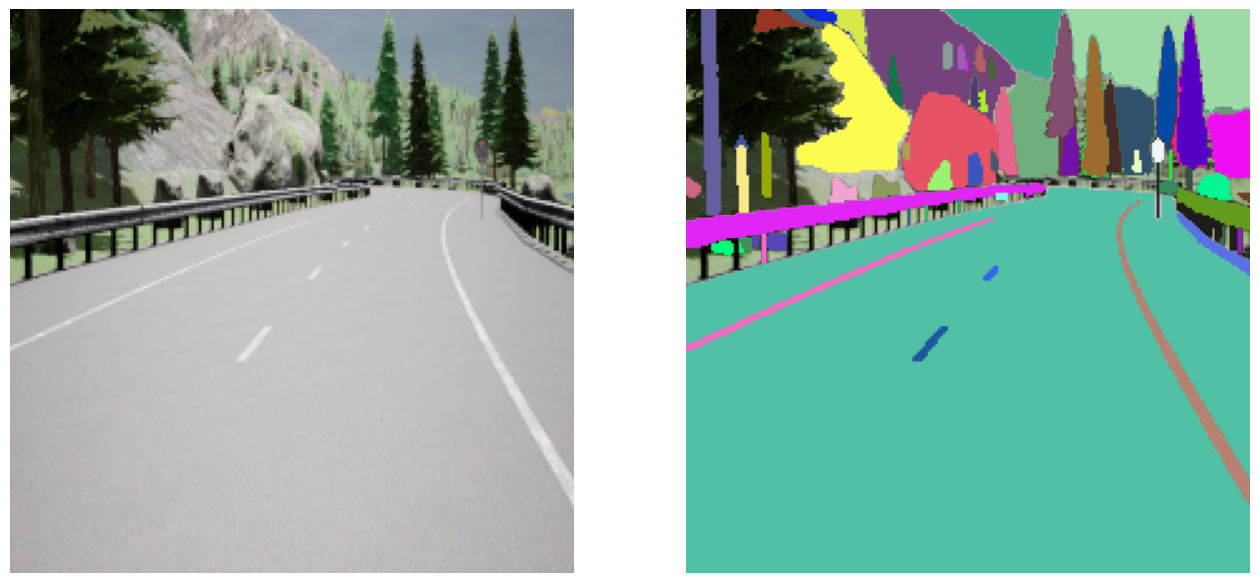

In [6]:

num_images = 10
random_indices = random.sample(range(len(dataset)), num_images)
image_tensor= dataset[0]
image_path = "/kaggle/input/lane-detection-for-carla-driving-simulator/val/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2145_validation_set.png"
image_information = cv2.imread(image_path)
image = cv2.resize(image_information, (224,224))
masks = mask_generator1.generate(image)


image_np = image_tensor.numpy()
# Reshape the image data to a valid shape
image_data = np.moveaxis(image_np, 0, -1)  # Move the channels axis to the last position
print(image_data.shape)  # Output: (256, 256, 3)
# Plot the original image and the mask


# Plot the original image and the mask
fig, axs = plt.subplots(1, 2, figsize=(16, 16))
axs[0].imshow(image)
axs[1].imshow(image)
detect_lanes(masks, axs[1])
axs[0].axis('off')
axs[1].axis('off')
plt.show()

In [7]:
import matplotlib.pyplot as plt

In [8]:
# Save the plot as an image file
plt.savefig('lane_detection_plot.png')

<Figure size 640x480 with 0 Axes>

# Genetic Algorithm 

In [9]:
import cv2

# Load the image
image_path = "/kaggle/input/lane-detection-for-carla-driving-simulator/train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_0.png"  # Replace with the path to your image
image = cv2.imread(image_path)

# Get the height and width of the image
height, width = image.shape[:2]

print("Image size (width, height):", (width, height))

Image size (width, height): (1024, 512)


In [10]:
import cv2
import numpy as np
import glob
import os

def generate_ground_truth_masks(annotation_dir, image_size):
    """
    Generate ground truth masks for lane detection based on lane annotations.
    
    Parameters:
        annotation_dir (str): Path to the directory containing lane annotations.
        image_size (tuple): Size of the images (height, width).
    
    Returns:
        list: List of ground truth masks corresponding to the annotated images.
    """
    # List to store ground truth masks
    ground_truth_masks = []
    
    # Load lane annotations and create ground truth masks
    for image_path in glob.glob(os.path.join(annotation_dir, '*.png')):
        # Read annotation image
        annotation_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        # Convert annotation to binary mask
        annotation_mask = (annotation_image > 0).astype(np.uint8)
        
        # Resize mask to match image size
        annotation_mask_resized = cv2.resize(annotation_mask, image_size[::-1])
        
        # Append to the list of ground truth masks
        ground_truth_masks.append(annotation_mask_resized)
    
    return ground_truth_masks

In [11]:
annotation_dir = "/kaggle/input/lane-detection-for-carla-driving-simulator/train_label"
image_size = (1024, 512)  # Example image size
ground_truth_masks = generate_ground_truth_masks(annotation_dir, image_size)

In [12]:
for idx, mask in enumerate(ground_truth_masks):
    print(f"Ground truth mask {idx + 1}:")
    print(mask)
    print("Shape:", mask.shape)

Ground truth mask 1:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Shape: (1024, 512)
Ground truth mask 2:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Shape: (1024, 512)
Ground truth mask 3:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Shape: (1024, 512)
Ground truth mask 4:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Shape: (1024, 512)
Ground truth mask 5:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Shape: (1024, 512)
Ground truth mask 6:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Shape: (1024, 512)
Ground truth mask 7:
[[0 0 0 ... 0 0 0]


In [13]:
import os
import cv2
import numpy as np
from PIL import Image
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import glob


In [14]:
class ObjectDetectionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = sorted(glob.glob(os.path.join(root_dir, '*.png')))
        print(f"Number of images: {len(self.image_paths)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image


In [15]:
def draw_polygon(event, x, y, flags, param):
    global drawing, points

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        points = [(x, y)]
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            points.append((x, y))
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        points.append((x, y))


# Global variables for manual annotation
drawing = False
points = []


In [16]:
# Load image dataset
root_dir = "/kaggle/input/lane-detection-for-carla-driving-simulator/train"
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
dataset = ObjectDetectionDataset(root_dir=root_dir, transform=transform)
loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Load SAM model
sam_checkpoint = '/kaggle/input/segment-anything/pytorch/vit-l/1/model.pth'
model_type = "vit_l"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam, points_per_batch=16)
predictor = SamPredictor(sam)

Number of images: 3075


In [17]:

def detect_lanes(anns, axes=None):
    if len(anns) == 0:
        return
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m**0.5)))

In [18]:
def segment_image(image, thresholds):
    # Apply thresholding individually for each pixel
    segmented_image = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            segmented_image[i, j] = 1 if image[i, j] > thresholds[i, j] else 0
    return segmented_image

In [19]:
import numpy as np

def genetic_algorithm(image_shape, ground_truth_masks, n_bins=256, n_population=20, n_iterations=50, 
                      p_selection=0.1, p_crossover=0.8, p_mutation=0.1):
    population = initialization(n_population, image_shape, n_bins)

    for i in range(n_iterations):
        new_population = []

        # Evaluation of fitness
        ranking = fitness(population, ground_truth_masks)

        # Selection
        new_population = first_best(ranking, population, p_selection, new_population)

        # Crossover
        new_population = crossover(population, p_crossover, new_population)

        # Mutation
        new_population = mutation(population, n_bins, p_mutation, new_population)

        population = new_population

    return population


In [20]:
def initialization(n_population, image_shape, n_bins):
    population = []
    for _ in range(n_population):
        thresholds = np.random.randint(0, n_bins, size=image_shape)
        population.append(thresholds)
    return population

In [21]:
def fitness(population, ground_truth_masks):
    fitness_scores = []
    for thresholds in population:
        # Apply segmentation using the thresholds
        segmented_images = [segment_image(thresholds, mask) for mask in ground_truth_masks]
        # Compute accuracy based on ground truth masks
        accuracy = calculate_accuracy(ground_truth_masks, segmented_images)
        fitness_scores.append(accuracy)
    return fitness_scores

In [22]:
def first_best(ranking, population, p_selection, new_population):
    n_selected = int(p_selection * len(population))
    best_indices = np.argsort(ranking)[-n_selected:]
    selected_individuals = [population[i] for i in best_indices]
    return selected_individuals

In [23]:
def crossover(population, p_crossover, new_population):
    n_crossovers = int(p_crossover * len(population))
    for _ in range(n_crossovers):
        # Flatten the population list of 2D arrays into a single 1D array
        flattened_population = [individual.ravel() for individual in population]
        parent_indices = np.random.choice(len(flattened_population), size=2, replace=False)
        parent1, parent2 = [flattened_population[idx] for idx in parent_indices]
        
        # Reshape the parents to their original shape
        parent_shape = population[0].shape
        parent1 = parent1.reshape(parent_shape)
        parent2 = parent2.reshape(parent_shape)

        crossover_point = np.random.randint(1, parent1.size)
        child = np.concatenate((parent1.ravel()[:crossover_point], parent2.ravel()[crossover_point:]))
        child = child.reshape(parent_shape)
        new_population.append(child)
    return new_population

In [24]:
def mutation(population, n_bins, p_mutation, new_population):
    for individual in population:
        if np.random.rand() < p_mutation:
            mutation_point = np.random.randint(len(individual))
            individual[mutation_point] = np.random.randint(n_bins)
    return population

In [25]:
def segment_image(thresholds, mask):
    segmented_image = np.zeros_like(mask)  # Initialize segmented image with zeros
    
    # Apply segmentation using the thresholds
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            # Find the index of the closest threshold for the current pixel
            idx = np.argmin(np.abs(thresholds - mask[i, j]))
            # Assign the corresponding segmented value based on the threshold
            segmented_image[i, j] = idx
            
    return segmented_image


In [26]:
def calculate_accuracy(ground_truth_masks, segmented_images):
    # Example accuracy calculation
    correct_predictions = sum(1 for gt_mask, seg_mask in zip(ground_truth_masks, segmented_images) if np.array_equal(gt_mask, seg_mask))
    total_predictions = len(ground_truth_masks)
    accuracy = correct_predictions / total_predictions * 100
    return accuracy

In [27]:
import numpy as np

# Example function to compute accuracy
def compute_accuracy(predicted_masks, ground_truth_masks):
    # Compute accuracy (for demonstration, replace with your actual accuracy computation)
    accuracy = np.mean(predicted_masks == ground_truth_masks)
    return accuracy

# Example data (replace with your actual data)
num_images = 3075
image_size = (256, 256)  # Example image size
num_classes = 2  # Example number of segmentation classes

# Generate random predicted and ground truth masks for demonstration
predicted_masks = np.random.randint(0, num_classes, size=(num_images,) + image_size)
ground_truth_masks = np.random.randint(0, num_classes, size=(num_images,) + image_size)

# Define batch size for processing
batch_size = 100

# Compute accuracy in batches
total_accuracy = 0.0
for i in range(0, num_images, batch_size):
    batch_predicted_masks = predicted_masks[i:i+batch_size]
    batch_ground_truth_masks = ground_truth_masks[i:i+batch_size]
    
    # Compute accuracy for the current batch
    batch_accuracy = compute_accuracy(batch_predicted_masks, batch_ground_truth_masks)
    total_accuracy += batch_accuracy * len(batch_predicted_masks)

# Compute overall accuracy
overall_accuracy = total_accuracy / num_images

print("Overall accuracy:", overall_accuracy)


Overall accuracy: 0.49999843194232724


# Genetic Programming